In [1]:
import numpy as np #Generate Orthogonal Polynomials
# Enable interactive plots
def generate_orthogonal_polynomials(omegas, order, weights):
    """
    Generate orthogonal polynomials using the Forsythe method and build the conversion matrix
    to map from orthogonal polynomial coefficients to ordinary polynomial coefficients.

    Parameters:
    omegas (array): Frequency points (real-valued)
    order (int): Maximum order of polynomials to generate
    weights (array): Weighting function values at each frequency point

    Returns:
    tuple: (
        complex_F: Complex orthogonal polynomials with shape (len(omegas), order+1),
        Gamma: Conversion matrix with shape (order+1, order+1) that maps from orthogonal
           to ordinary polynomial coefficients
    )
    """
    # Find number of frequency points
    n_frequencies = len(omegas)

    # Initialize array to store polynomials
    complex_F = np.zeros((n_frequencies, order + 1), dtype=complex)
    F = np.zeros((n_frequencies, order + 1), dtype=float)
    G = np.zeros((n_frequencies, order + 1), dtype=float)
    V = np.zeros(order + 1, dtype=float)

    # Initialize conversion matrix Gamma
    # Gamma[k,j] = coefficient of s^j in the k-th orthogonal polynomial
    Gamma = np.zeros((order + 1, order + 1))

    # coeff_arrays is a list of arrays, where each array represents one orthogonal polynomial in terms of powers of s
    # coeff_arrays[k] contains the coefficients of the k-th orthogonal polynomial φₖ(s)
    # coeff_arrays[k][j] holds the coefficient of s^j in the expansion of φₖ(s)
    coeff_arrays = [np.zeros(order + 1) for _ in range(order + 1)]

    # Calculate polynomials for k=0
    p0 = 1.0 / np.sqrt(np.sum(weights))  # coefficient for φ₀(s)
    F[:, 0] = p0  # for k=0 the orthogonal polynomial is constant
    complex_F[:, 0] = F[:, 0] * (1j**0)

    # Assign value of the coefficient of s^0 in φ₀(s)
    coeff_arrays[0][0] = p0
    Gamma[0, 0] = p0

    # Calculate polynomials for k=1
    G[:, 1] = omegas * F[:, 0]  # F[:,-1]=0, V[0]=0
    norm_factor = np.sqrt(np.sum(G[:, 1] ** 2 * weights))
    F[:, 1] = G[:, 1] / norm_factor
    complex_F[:, 1] = F[:, 1] * (1j**1)

    # For k=1, the orthogonal polynomial is p1*s
    p1 = p0 / norm_factor
    coeff_arrays[1][1] = p1  # coefficient of s^1 in φ₁(s)
    Gamma[1, 1] = p1

    # Iterate from k=2 to k=order
    for k in range(2, order + 1):
        # Calculate V[k-1]
        V[k - 1] = np.sum(omegas * F[:, k - 1] * F[:, k - 2] * weights)

        # Calculate G[:, k]
        G[:, k] = omegas * F[:, k - 1] - V[k - 1] * F[:, k - 2]

        # Calculate norm_factor
        norm_factor = np.sqrt(np.sum(G[:, k] ** 2 * weights))

        # Calculate F[:, k]
        F[:, k] = G[:, k] / norm_factor

        # Calculate complex polynomials
        complex_F[:, k] = F[:, k] * (1j**k)

        # Update coefficient arrays for this orthogonal polynomial
        # φₖ(s) = (s*φₖ₋₁(s) - V[k-1]*φₖ₋₂(s)) / norm_factor

        # First part: s*φₖ₋₁(s) -> shift coefficients up by one power of s
        temp_coeffs = np.zeros(
            order + 1
        )  # holds intermediate calculation before normalization
        for i in range(order):
            temp_coeffs[i + 1] = coeff_arrays[k - 1][i]

        # Second part: subtract V[k-1]*φₖ₋₂(s)
        for i in range(order + 1):
            temp_coeffs[i] -= V[k - 1] * coeff_arrays[k - 2][i]

        # Normalize
        coeff_arrays[k] = temp_coeffs / norm_factor

        # Update conversion matrix Gamma with these coefficients
        Gamma[k, :] = coeff_arrays[k]

    # Return the complex orthogonal polynomials and the conversion matrix
    return complex_F, Gamma

In [2]:
def grfp_curve_fit(frequencies, frfs, numerator_order, denominator_order):
    """
    Implements the Global Rational Fraction Polynomial (GRFP) method for curve fitting
    multiple FRF measurements simultaneously.

    Parameters:
    ----------
    frequencies : ndarray
        Array of frequency points (should be a set of symmetric frequencies around zero)
    frfs : ndarray
        Array of FRF measurements with shape (n_dofs, n_frequencies)
    numerator_order : int
        Order of the numerator polynomial
    denominator_order : int
        Order of the denominator polynomial

    Returns:
    -------
    tuple
        - a_coeffs: List of numerator ordinary polynomial coefficients for each DOF
        - b_coeffs: Denominator ordinary polynomial coefficients
    """
    # Find number of response FRFs and frequency points
    n_dofs = frfs.shape[0]
    n_freqs = frequencies.shape[0]

    # Create weights for polynomials
    # For numerator: uniform weighting
    numerator_weights = np.ones_like(frequencies)

    # For denominator: sum of squared magnitudes of all FRFs
    denominator_weights = np.sum(np.abs(frfs) ** 2, axis=0)

    # Generate numerator orthogonal polynomials
    phi, Gamma_numerator = generate_orthogonal_polynomials(
        frequencies, numerator_order, numerator_weights
    )

    # Generate denominator orthogonal polynomials
    theta, Gamma_denominator = generate_orthogonal_polynomials(
        frequencies, denominator_order, denominator_weights
    )

    # Setup matrices for the squared-error minimization problem
    D_T_list = []  # D_T,j matrices
    X_list = []  # X_j matrices
    H_list = []  # H_j vectors

    # Loop through each degree of freedom
    for j in range(n_dofs):
        # Calculate T_j matrix
        T_j = (
            theta[:, :-1] * frfs[j][:, np.newaxis]
        )  # Broadcasting to create T_j matrix

        # Calculate D_T,j matrix
        D_T_j = np.diag(
            np.sum(np.abs(T_j) ** 2, axis=0)
        )  # Diagonal matrix of sum of squares along frequency points
        D_T_list.append(D_T_j)

        # Calculate X_j matrix
        X_j = -np.real(phi.conj().T @ T_j)
        X_list.append(X_j)

        # Calculate W_j vector
        W_j = frfs[j] * theta[:, -1]

        # Calculate H_j vector
        H_j = np.real(phi.conj().T @ W_j)
        H_list.append(H_j)

    # Calculate left and right-hand sides of the linear system for the denominator coefficients
    LHS = np.sum([D_Tj for D_Tj in D_T_list], axis=0) - np.sum(
        [X_j.T @ X_j for X_j in X_list], axis=0
    )
    RHS = -np.sum([X_j.T @ H_j for X_j, H_j in zip(X_list, H_list)], axis=0)

    # Solve for denominator coefficients d
    D = np.linalg.solve(LHS, RHS)

    # Add the last coefficient (d_n = 1)
    d_coeffs = np.append(D, 1)

    # Convert orthogonal denominator coefficients to ordinary denominator coefficients
    b_coeffs = np.zeros(denominator_order + 1, dtype=complex)
    for i in range(denominator_order + 1):
        b_coeffs[i] = np.sum(
            d_coeffs[i:]
            * Gamma_denominator[i:, i]
            * 1j ** (np.arange(denominator_order + 1 - i))
        )

    # Calculate numerator coefficients c_j for each DOF and convert to ordinary coefficients
    # Initialize lists for coefficients
    a_coeffs_list = []
    c_coeffs_list = []

    # Loop through each degree of freedom
    for j in range(n_dofs):
        # Find orthogonal coefficients
        C_j = H_list[j] - X_list[j] @ D
        c_coeffs_list.append(C_j)

        # Convert orthogonal coefficients to ordinary coefficients
        a_coeffs_list.append(np.zeros(numerator_order + 1, dtype=complex))
        for i in range(numerator_order + 1):
            a_coeffs_list[j][i] = np.sum(
                c_coeffs_list[j][i:]
                * Gamma_numerator[i:, i]
                * 1j ** (np.arange(numerator_order + 1 - i))
            )

    # Return the coefficients and conversion matrices
    return a_coeffs_list, b_coeffs, c_coeffs_list, d_coeffs, phi, theta

In [3]:
# from scipy.io import loadmat
# import numpy as np
# # Select numerator and denominator orders
# numerator_order = 2
# denominator_order = 4

# f_sampling = 100

# data = loadmat("fit_myMATLAB.mat")
# frequencies = data["frequencies"].flatten()
# frfs = data["frfs"].reshape(2,256)


# # Take symmetric frequency points around zero (exclude Nyquist frequency point)
# symmetric_mask = np.abs(frequencies) < f_sampling / 2
# symmetric_angular_frequencies = 2 * np.pi * frequencies[symmetric_mask]

# # Perform global curve fitting
# a_coeffs_list, b_coeffs, _, _, _, _ = grfp_curve_fit(
#     symmetric_angular_frequencies, frfs2[:,symmetric_mask], numerator_order, denominator_order)

In [4]:
import matplotlib.pyplot as plt  # Plot spectrum


def plot_spectrum(
    frequencies, spectrum, unwrap=False, axes=None, label=None, title=None
):
    """Plot magnitude and phase spectrum of a signal

    Parameters:
    frequencies (array): Frequency vector of full spectrum (positive and negative frequencies)
    spectrum (array): Complex spectrum values
    unwrap (bool): Unwrap phase if True (optional)
    axes (array): Axes to plot on (optional)
    label (str): Label for the plot (optional)
    title (str): Plot title (optional)
    """
    # Get positive frequencies only (since spectrum is symmetric for real signals)
    pos_mask = frequencies >= 0
    pos_freqs = frequencies[pos_mask]
    pos_spectrum = spectrum[pos_mask]

    # Calculate magnitude in dB and phase in radians
    magnitude_db = 20 * np.log10(np.abs(pos_spectrum))
    phase = np.angle(pos_spectrum)

    # Unwrap phase if specified
    if unwrap:
        phase = np.unwrap(phase)

    # Convert phase to degrees
    # phase = np.rad2deg(phase)
    # for i in range(len(phase)):
    #     if phase[i] <=-180:
    #         phase[i] = 180+(phase[i]+180)
    # Create figure with two subplots if axes are not provided
    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    else:
        fig = axes[0].figure

    # Plot magnitude
    axes[0].plot(pos_freqs, magnitude_db, label=label)
    axes[0].set_ylabel("Magnitude (dB)")
    axes[0].grid(True)

    # Plot phase
    axes[1].plot(pos_freqs, phase)
    axes[1].set_ylabel("Phase, deg")
    axes[1].set_xlabel("Frequency, Hz")
    axes[1].grid(True)

    # Set title if provided
    if title:
        axes[0].set_title(f"{title} Magnitude Spectrum")
        axes[1].set_title(f"{title} Phase Spectrum")

    # Return figure and axes for further customization if needed
    return fig, axes

In [5]:
# import matplotlib.pyplot as plt  # import matplotlib library for plotting

# _, _ = plot_spectrum(frequencies, frfs[0,:], unwrap=True, title="$x_1$ FRF")
# plt.show()
# _, _ = plot_spectrum(frequencies, frfs[1,:], unwrap=True, title="$x_2$ FRF")
# plt.show()


In [6]:
from scipy import signal #Calculate H1 frf

def calculate_h1_frf(
    input_signal, output_signal_array, fs, window="hann", nperseg=None, noverlap=None
):
    """
    Calculate the Frequency Response Function (FRF) with the H1 estimator and using SciPy's implementation of Welch's method.

    This function computes the H1 estimator: H1(f) = Gxy(f)/Gxx(f), where:
    - Gxy(f) is the cross-spectral density between input and output
    - Gxx(f) is the power spectral density of the input

    Parameters:
    -----------
    input_signal : array_like
        Input force signal
    output_signal_array : ndarray
        Array of output displacement signals with shape (n_outputs, n_samples)
    fs : float
        Sampling frequency of the signals
    window : str or tuple or array_like
        Window specification for the spectral estimation (default: 'hann')
    nperseg : int, optional
        Length of each segment (default: min(N, 256) where N is signal length)
    noverlap : int, optional
        Number of points to overlap between segments (default: nperseg//2)

    Returns:
    --------
    freqs : ndarray
        Array of sample frequencies
    frf : ndarray
        Array of FRFs for each output signal with shape (n_outputs, n_frequencies)
    """
    # Find number of output responses and initialize list of FRFs
    n_outputs = output_signal_array.shape[0]
    frfs = []

    # Process each output channel
    for i in range(n_outputs):
        # Calculate cross-spectral density between input and output
        # This gives us Gxy(f)
        f, Gxy = signal.csd(
            input_signal,
            output_signal_array[i],
            fs=fs,
            window=window,
            nperseg=nperseg,
            noverlap=noverlap,
            detrend="constant",
            return_onesided=False,
        )

        # Calculate power spectral density of the input
        # This gives us Gxx(f)
        _, Gxx = signal.welch(
            input_signal,
            fs=fs,
            window=window,
            nperseg=nperseg,
            noverlap=noverlap,
            detrend="constant",
            return_onesided=False,
        )

        # Calculate H1 estimator: H1(f) = Gxy(f)/Gxx(f)
        frf_channel = Gxy / Gxx
        frfs.append(frf_channel)

    # Return the frequencies and FRFs
    return f/2, np.array(frfs)

In [7]:
def calculate_fitted_frf(angular_frequencies, a_coeffs_list, b_coeffs):
    """
    Calculate the fitted FRF using the polynomial coefficients.

    Parameters:
    ----------
    angular_frequencies : ndarray
        Array of angular frequencies (rad/s)
    a_coeffs_list : list
        List of numerator polynomial coefficients for each DOF
    b_coeffs : ndarray
        Denominator polynomial coefficients

    Returns:
    -------
    fitted_frf : ndarray
        Fitted FRF for each DOF
    """
    # Initialize arrray to store fitted FRFs
    fitted_frfs = np.zeros((len(a_coeffs_list), len(angular_frequencies)), dtype=complex)

    # Loop through each degree of freedom to compare measured and fitted FRFs
    for j in range(N_DOFS):
        # Calculate fitted FRF using the polynomial coefficients
        num = np.polyval(a_coeffs_list[j][::-1], 1j * angular_frequencies)
        den = np.polyval(b_coeffs[::-1], 1j * angular_frequencies)
        fitted_frfs[j] = num / den

    # Return the fitted FRFs
    return fitted_frfs


In [8]:
def extract_poles(b_coeffs):
    """
    Extract poles from the denominator polynomial coefficients.

    Parameters:
    ----------
    b_coeffs : ndarray
        Denominator ordinary polynomial coefficients

    Returns:
    -------
    tuple:
        - natural_freqs: array of natural frequencies (rad/s) of size (n_modes,)
        - damping_ratios: array of damping ratios of size (n_modes,)
        - pole_pairs: array of complex conjugate pole pairs of size (n_modes, 2)
    """
    # Find roots of the denominator polynomial
    lambdas = np.roots(b_coeffs[::-1])

    # Initialize array of pole pairs, natural frequencies, and damping ratios
    n_modes = len(lambdas) // 2
    pole_pairs = np.zeros((n_modes, 2), dtype=complex)
    natural_freqs = np.zeros(n_modes, dtype=float)
    damping_ratios = np.zeros(n_modes, dtype=float)

    # Process poles to find complex conjugate pairs
    remaining_poles = lambdas.copy()
    i = 0
    while len(remaining_poles) > 0:
        # Take the first pole as the reference pole
        p = remaining_poles[0]

        # Calculate square root distance to other poles
        distances = np.sqrt(
            (remaining_poles[1:].real - p.real) ** 2
            + (remaining_poles[1:].imag + p.imag) ** 2
        )

        # Find the closest pole
        closest_idx = np.argmin(distances) + 1
        closest_pole = remaining_poles[closest_idx]

        # Store the pole pair
        pole_pairs[i] = np.array([p, closest_pole])

        # Calculate natural frequency
        natural_freqs[i] = np.abs(p)

        # Calculate damping ratio
        damping_ratios[i] = -p.real / np.abs(p)

        # Remove the processed poles from the list and update the index
        remaining_poles = np.delete(remaining_poles, [0, closest_idx])
        i += 1

    # Sort arrays by natural frequency (ascending)
    sort_indices = np.argsort(natural_freqs)
    pole_pairs = pole_pairs[sort_indices]
    natural_freqs = natural_freqs[sort_indices]
    damping_ratios = damping_ratios[sort_indices]

    # Return results
    return natural_freqs, damping_ratios, pole_pairs

In [9]:
# Get default matlpotlib colors  Calculate modes
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def calculate_modes(a_coeffs_list, pole_pairs, drive_index=1):
    """
    Calculate mode shapes from the numerator coefficients and poles.

    Parameters:
    ----------
    a_coeffs_list : list
        List of numerator ordinary polynomial coefficients for each DOF
    pole_pairs : ndarray
        Array of complex conjugate pole pairs of size (n_modes, 2)
    drive_index : int
        Index of the driving point (default: 1 for second DOF)

    Returns:
    -------
    tuple:
        - residues: Residues for each DOF and mode
        - modes: Mode shapes (normalized)
    """
    # Find number of degrees of freedom and modes
    n_dofs = len(a_coeffs_list)
    n_modes = pole_pairs.shape[0]

    # Find numerator polynomial order
    numerator_order = len(a_coeffs_list[0]) - 1

    # Initialize arrays for residues and mode shapes
    residues = np.zeros((n_dofs, n_modes), dtype=complex)
    modes = np.zeros((n_dofs, n_modes))

    # Loop through each degree of freedom
    for j in range(n_dofs):
        # Calculate residues for each mode
        for i in range(n_modes):
            poles = pole_pairs[i]
            remaining_poles = np.delete(pole_pairs, i, axis=0)
            residues[j, i] = np.sum(
                a_coeffs_list[j] * poles[0] ** np.arange(numerator_order + 1)
            ) / (
                (poles[0] - poles[1])
                * np.prod(
                    (poles[0] - remaining_poles[:, 0])
                    * (poles[0] - remaining_poles[:, 1])
                )
            )

    # Use the driving point residues to normalize mode shapes
    # Scale factor is square root of driving point residues
    # v_jr = R_jr / sqrt(R_2r)
    scale_factors = np.sqrt(residues[drive_index, :])

    # Iterate over each degree of freedom
    for j in range(n_dofs):
        # Calculate ratios of residues to scale factors
        ratios = residues[j, :] / scale_factors
        # Extract every second element (since poles are complex conjugate pairs) and take the real part
        modes[j, :] = ratios.real

    # Normalize mode shapes to unit length
    norms = np.linalg.norm(modes, axis=0)
    modes /= norms

    # Return the mode shapes
    return modes

# Varying order model to check which one fits best

# Define order range for denominator polynomial
order_range = range(4, 16, 2)

# Initialize list of dictionaries to store modal parameters
modal_params_list = []

# Iterate over each order
for order in order_range:
    # Perform global curve fitting
    a_coeffs_list, b_coeffs, _, _, _, _ = grfp_curve_fit(
        symmetric_angular_frequencies, frfs2_bien[:, symmetric_mask], order, order
    )
    
    # Estimate modal parameters from denominator coefficients
    estimated_natural_frequencies, estimated_damping_ratios, pole_pairs = extract_poles(
        b_coeffs
    )

    # Calculate estimated mode shapes
    estimated_modes = calculate_modes(a_coeffs_list, pole_pairs)

    # Store modal parameters in dictionary
    result_dict = {
        "order": order,
        "frequencies": estimated_natural_frequencies,
        "dampings": estimated_damping_ratios,
        "mode_shapes": estimated_modes,
    }
    print(result_dict)
    print("\n")
    modal_params_list.append(result_dict)

In [10]:
import pandas as pd  # import pandas library for data manipulation
from matplotlib.lines import Line2D  # import Line2D for creating custom legends


def calculate_mac(mode_a, mode_b):
    """
    Calculate the Modal Assurance Criterion (MAC) between two mode shapes.

    Parameters:
    mode_a (array): Mode shape A
    mode_b (array): Mode shape B

    Returns:
    float: Modal Assurance Criterion (MAC) between mode shapes A and B
    """
    # Ensure mode shapes are oriented in the same direction
    if mode_a.T @ mode_b < 0:
        mode_b = -mode_b

    # Calculate numerator and denominator of MAC formula
    numerator = np.abs(mode_a.T @ mode_b) ** 2
    denominator = (mode_a.T @ mode_a) * (mode_b.T @ mode_b)

    # Return MAC value
    return numerator / denominator


def apply_stabilization_criteria(results, freq_tol=0.01, damp_tol=0.05, mac_tol=0.95):
    """
    Apply stabilization criteria to identify stable poles across model orders

    Parameters:
    results (list): List of dictionaries containing modal parameters for each order
    freq_tol (float): Frequency tolerance (relative)
    damp_tol (float): Damping tolerance (relative)
    mac_tol (float): MAC tolerance

    Returns:
    pandas.DataFrame: DataFrame containing stabilization information
    """
    # Create a list to store all modal results from all model orders
    all_models = []

    # Process each model order result
    for result in results:
        order = result["order"]
        frequencies = result["frequencies"]
        dampings = result["dampings"]
        mode_shapes = result["mode_shapes"]

        # Add each modal result of each model order to the list
        for i in range(len(frequencies)):
            all_models.append(
                {
                    "order": order,
                    "frequency": frequencies[i],
                    "freq_Hz": frequencies[i] / (2 * np.pi),
                    "damping": dampings[i],
                    "mode_shape": np.atleast_2d(mode_shapes[:, i]).T,
                    "mode_index": i,
                    "stability": "new",
                }
            )

    # Convert to DataFrame for easier manipulation
    stabilization_dataframe = pd.DataFrame(all_models)

    # Sort by order (ascending) and frequency (ascending)
    stabilization_dataframe = stabilization_dataframe.sort_values(
        by=["order", "frequency"]
    )

    # Initialize stability flags
    stabilization_dataframe["freq_stable"] = False
    stabilization_dataframe["damp_stable"] = False
    stabilization_dataframe["mac_stable"] = False
    stabilization_dataframe["fully_stable"] = False

    # For each model order (starting from the second one)
    orders = sorted(stabilization_dataframe["order"].unique())
    for i in range(1, len(orders)):
        current_order = orders[i]
        previous_order = orders[i - 1]

        # Get results from current order
        current_order_results = stabilization_dataframe[
            stabilization_dataframe["order"] == current_order
        ]

        # Get results from previous order
        previous_order_results = stabilization_dataframe[
            stabilization_dataframe["order"] == previous_order
        ]

        # For each mode in current model order
        for idx, current_mode in current_order_results.iterrows():
            # Find closest mode in previous order by frequency
            freq_diffs = np.abs(
                current_mode["frequency"] / previous_order_results["frequency"].values
                - 1
            )
            closest_idx = np.argmin(freq_diffs)
            closest_mode = previous_order_results.iloc[closest_idx]

            # Check frequency stability
            if freq_diffs[closest_idx] < freq_tol:
                stabilization_dataframe.loc[idx, "freq_stable"] = True

            # Check damping stability
            damp_diff = np.abs(current_mode["damping"] / closest_mode["damping"] - 1)
            if damp_diff < damp_tol:
                stabilization_dataframe.loc[idx, "damp_stable"] = True

            # Check MAC stability
            mac = calculate_mac(closest_mode["mode_shape"], current_mode["mode_shape"])
            if mac > mac_tol:
                stabilization_dataframe.loc[idx, "mac_stable"] = True

            # Check if fully stable
            if (
                stabilization_dataframe.loc[idx, "freq_stable"]
                and stabilization_dataframe.loc[idx, "damp_stable"]
                and stabilization_dataframe.loc[idx, "mac_stable"]
            ):
                stabilization_dataframe.loc[idx, "fully_stable"] = True
                stabilization_dataframe.loc[idx, "stability"] = "stable"

    # Return the DataFrame with stabilization information
    return stabilization_dataframe



c:\Users\ngs\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 7500 is greater than input length  = 6635, using nperseg = 6635
  warnings.warn('nperseg = {0:d} is greater than input length '


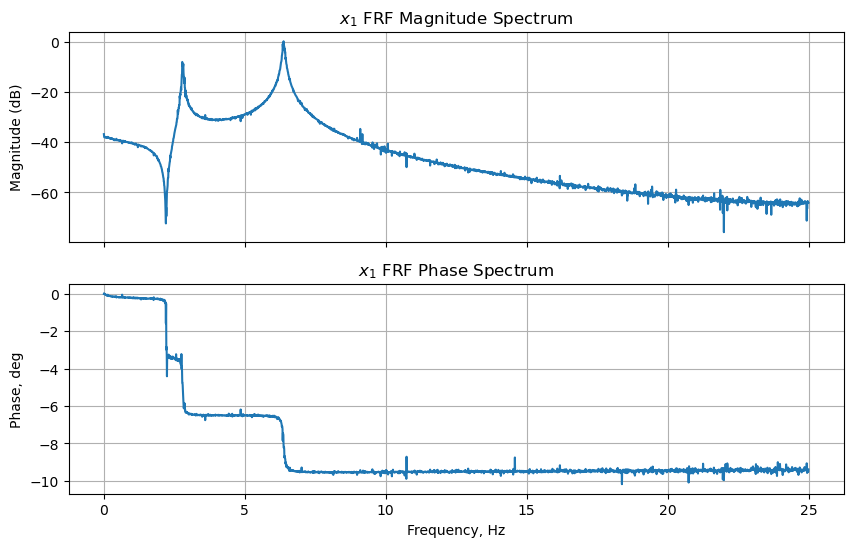

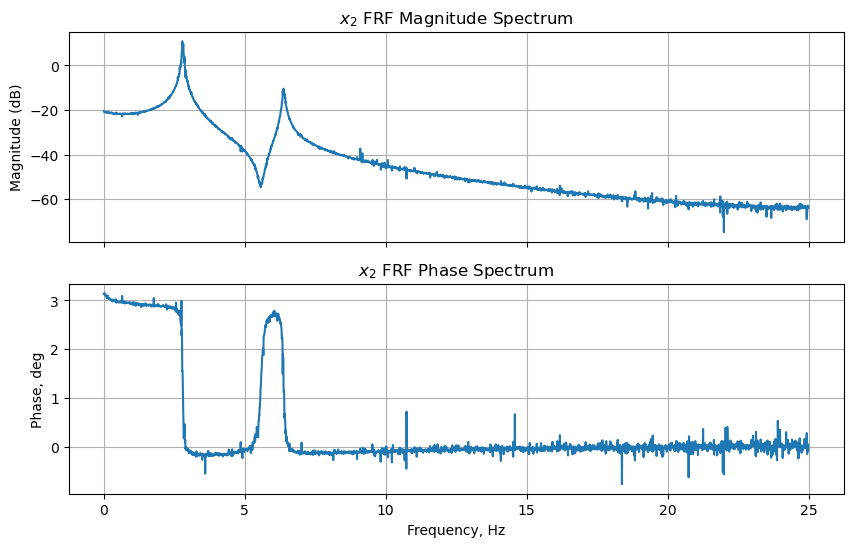

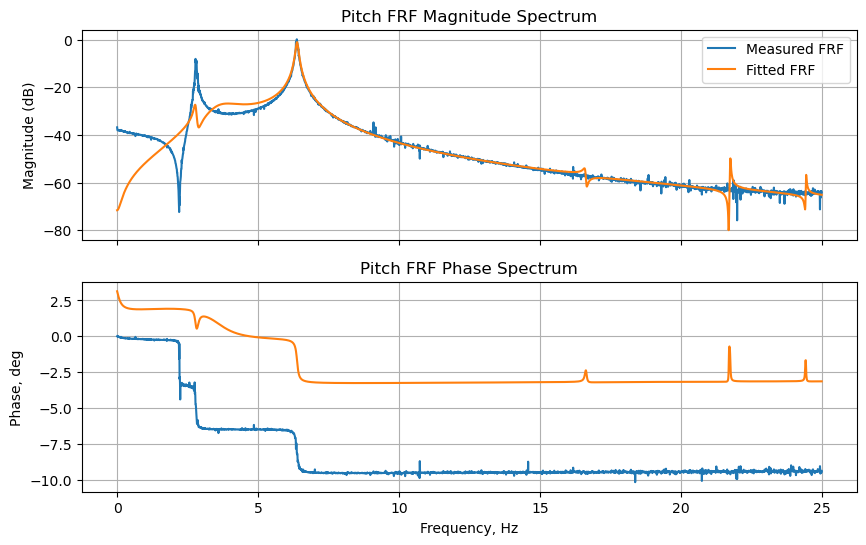

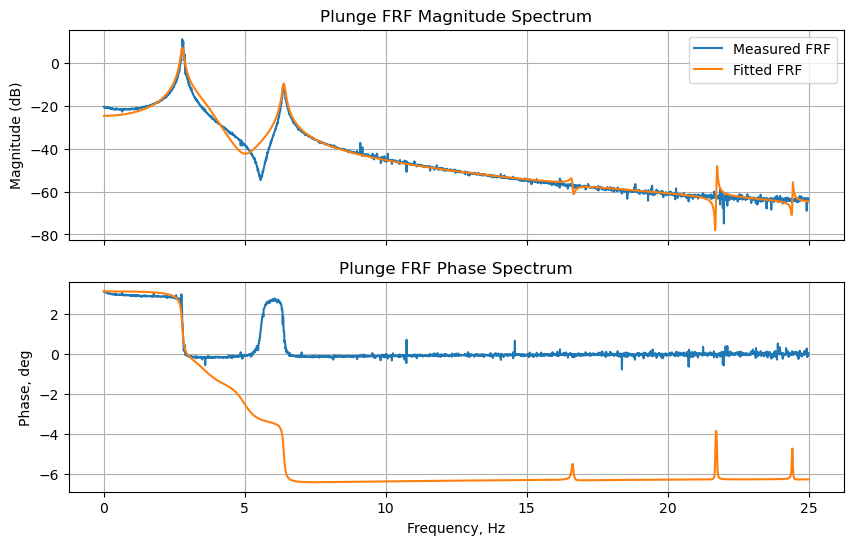

Mode 1
True natural frequency: 17.57 rad/s
Estimated natural frequency: 17.48 rad/s
Percentage error: -0.48%
True damping ratio: -0.01
Estimated damping ratio: 0.02
Percentage error: -290.47%

Mode 2
True natural frequency: 40.09 rad/s
Estimated natural frequency: 22.79 rad/s
Percentage error: -43.16%
True damping ratio: -0.01
Estimated damping ratio: 0.18
Percentage error: -2842.52%

{'order': 4, 'frequencies': array([17.44704721, 40.22184545]), 'dampings': array([0.00650326, 0.00640303]), 'mode_shapes': array([[ 0.5946834 , -0.96350709],
       [ 0.80395998,  0.2676828 ]])}


{'order': 6, 'frequencies': array([ 17.46784133,  40.10568766, 137.54427944]), 'dampings': array([0.00854786, 0.00551453, 0.00830376]), 'mode_shapes': array([[ 0.25410592, -0.98502079, -0.59887935],
       [ 0.9671764 ,  0.17243562,  0.80083926]])}


{'order': 8, 'frequencies': array([ 17.48039484,  40.06808777,  86.81379633, 146.35967096]), 'dampings': array([0.00952101, 0.00522477, 0.04213273, 0.00332694]), 'm

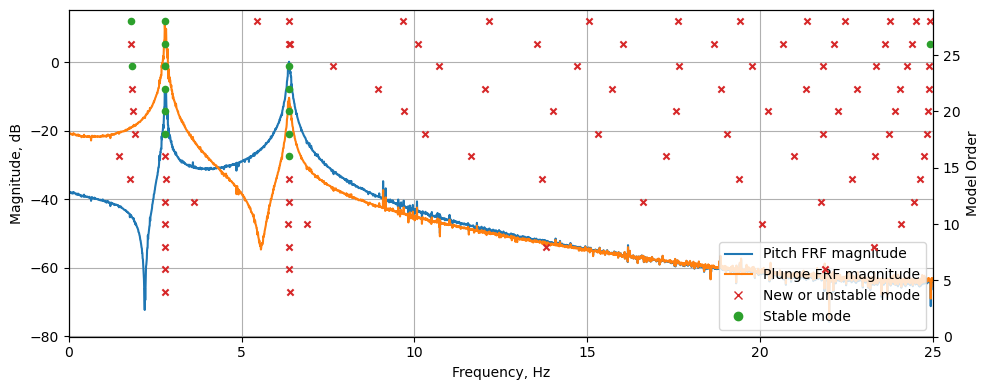

c:\Users\ngs\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 7500 is greater than input length  = 6635, using nperseg = 6635
  warnings.warn('nperseg = {0:d} is greater than input length '


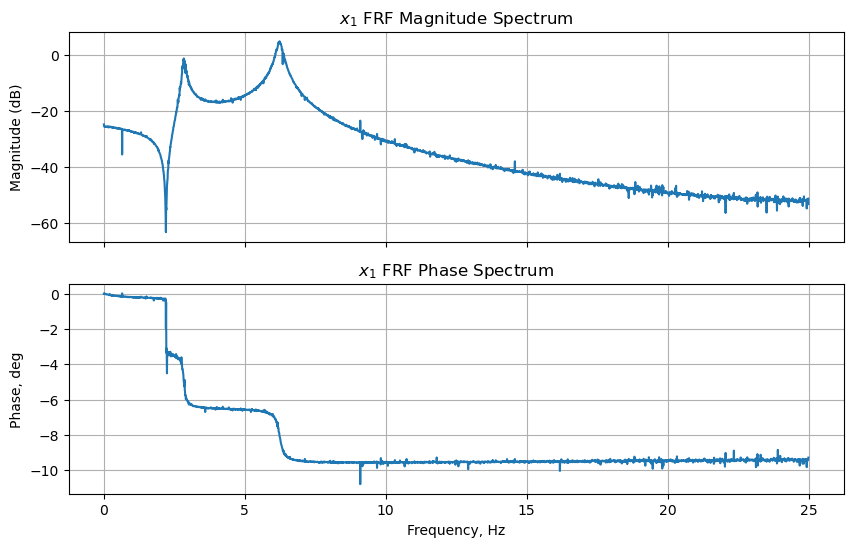

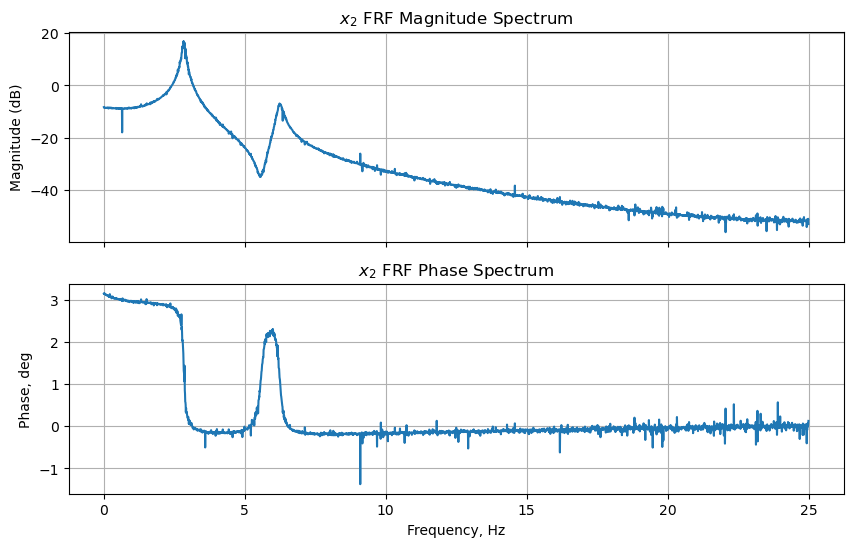

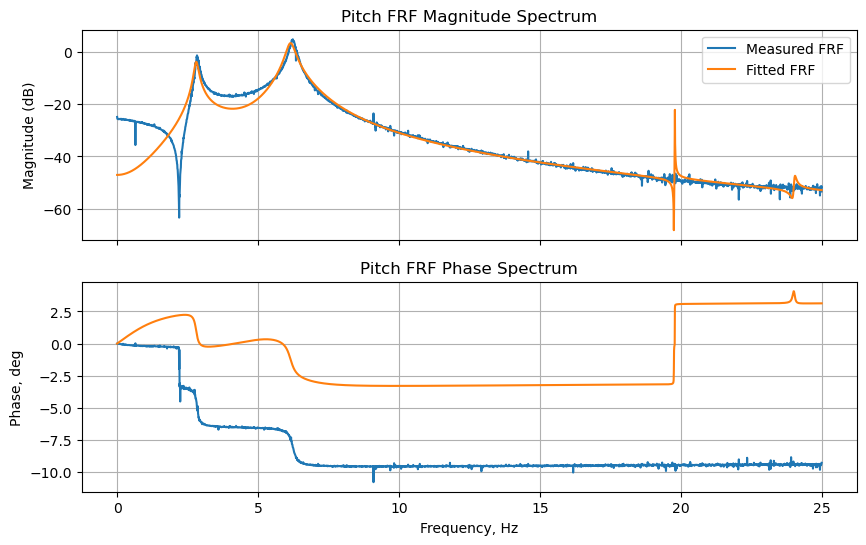

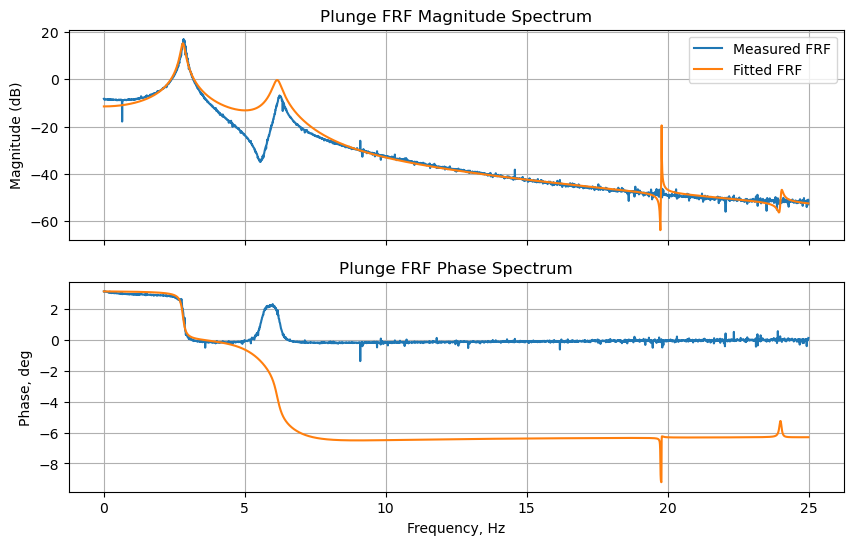

Mode 1
True natural frequency: 17.83 rad/s
Estimated natural frequency: 17.63 rad/s
Percentage error: -1.13%
True damping ratio: -0.02
Estimated damping ratio: 0.03
Percentage error: -224.76%

Mode 2
True natural frequency: 39.18 rad/s
Estimated natural frequency: 38.65 rad/s
Percentage error: -1.34%
True damping ratio: -0.02
Estimated damping ratio: 0.02
Percentage error: -238.49%

{'order': 4, 'frequencies': array([17.53286235, 39.5430061 ]), 'dampings': array([0.01488665, 0.01781022]), 'mode_shapes': array([[ 0.66081317, -0.8793077 ],
       [ 0.75055043,  0.47625411]])}


{'order': 6, 'frequencies': array([ 17.60314662,  39.28443501, 135.04967723]), 'dampings': array([0.01912089, 0.01436561, 0.01980226]), 'mode_shapes': array([[ 0.3152124 , -0.9205332 , -0.61598923],
       [ 0.94902115,  0.39066434,  0.78775457]])}


{'order': 8, 'frequencies': array([ 17.63747491,  39.16528141,  77.81976437, 146.22897054]), 'dampings': array([0.02161456, 0.01283053, 0.08649002, 0.00398841]), 'mod

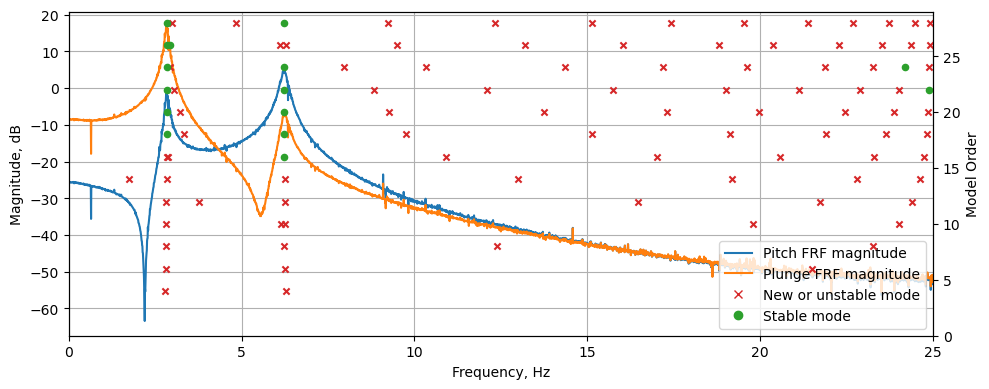

c:\Users\ngs\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 7500 is greater than input length  = 6635, using nperseg = 6635
  warnings.warn('nperseg = {0:d} is greater than input length '


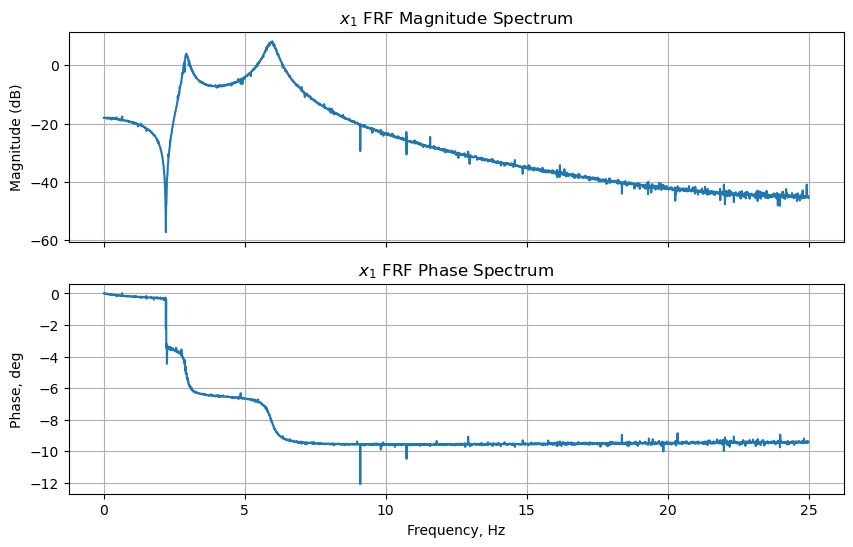

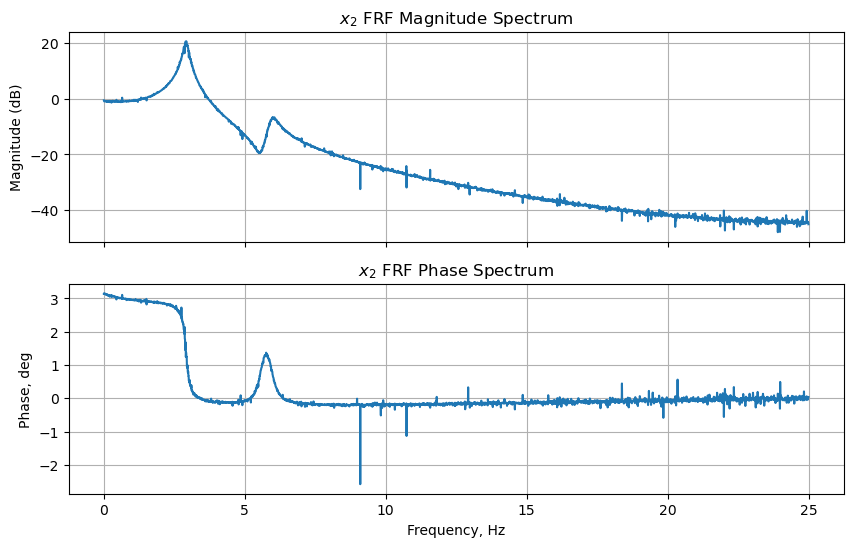

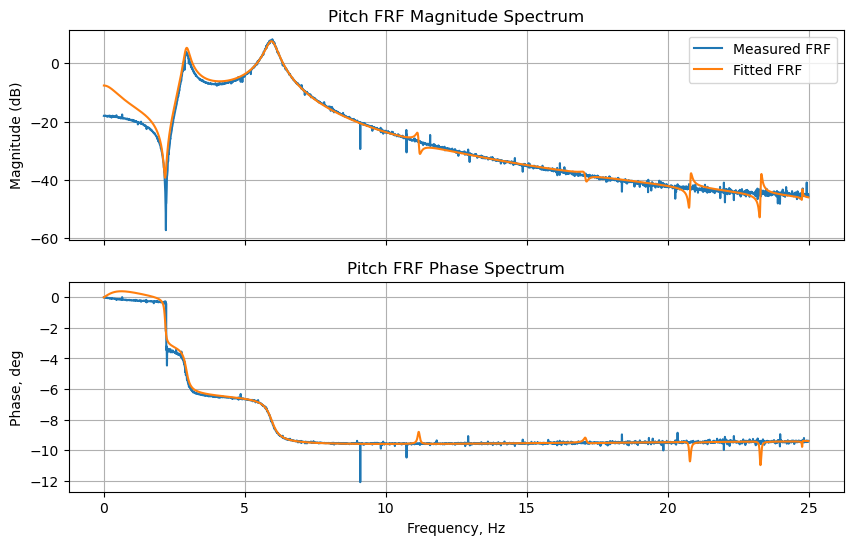

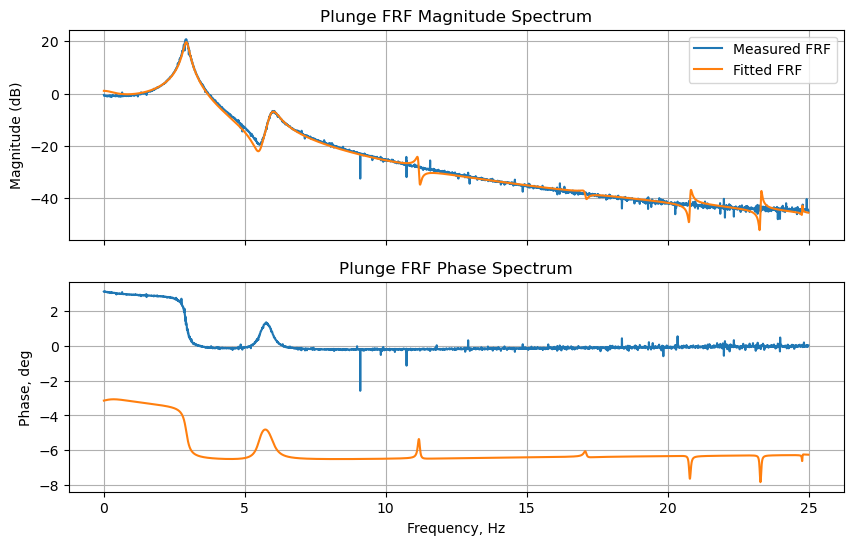

Mode 1
True natural frequency: 18.33 rad/s
Estimated natural frequency: 18.40 rad/s
Percentage error: 0.34%
True damping ratio: -0.03
Estimated damping ratio: 0.03
Percentage error: -204.86%

Mode 2
True natural frequency: 37.35 rad/s
Estimated natural frequency: 22.45 rad/s
Percentage error: -39.89%
True damping ratio: -0.03
Estimated damping ratio: 1.00
Percentage error: -3050.37%

{'order': 4, 'frequencies': array([17.83798051, 38.12793082]), 'dampings': array([0.02485269, 0.0377605 ]), 'mode_shapes': array([[ 0.73294398, -0.79352649],
       [ 0.680289  ,  0.6085357 ]])}


{'order': 6, 'frequencies': array([ 17.96408701,  37.63283762, 134.76414278]), 'dampings': array([0.03122484, 0.02861612, 0.02541383]), 'mode_shapes': array([[ 0.36314937, -0.43059691, -0.63080605],
       [ 0.93173094,  0.90254435,  0.77594054]])}


{'order': 8, 'frequencies': array([ 18.02514365,  37.40656631,  78.15056416, 146.77492999]), 'dampings': array([0.03538965, 0.02474314, 0.11314083, 0.00135745]), 'mo

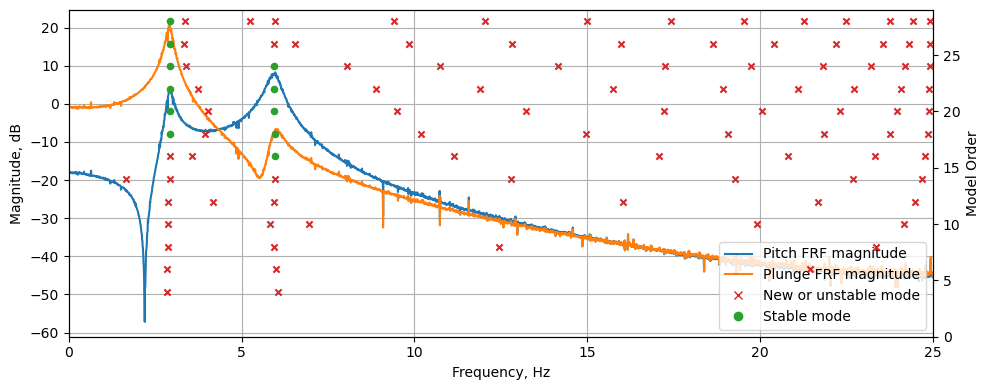

c:\Users\ngs\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 7500 is greater than input length  = 6635, using nperseg = 6635
  warnings.warn('nperseg = {0:d} is greater than input length '


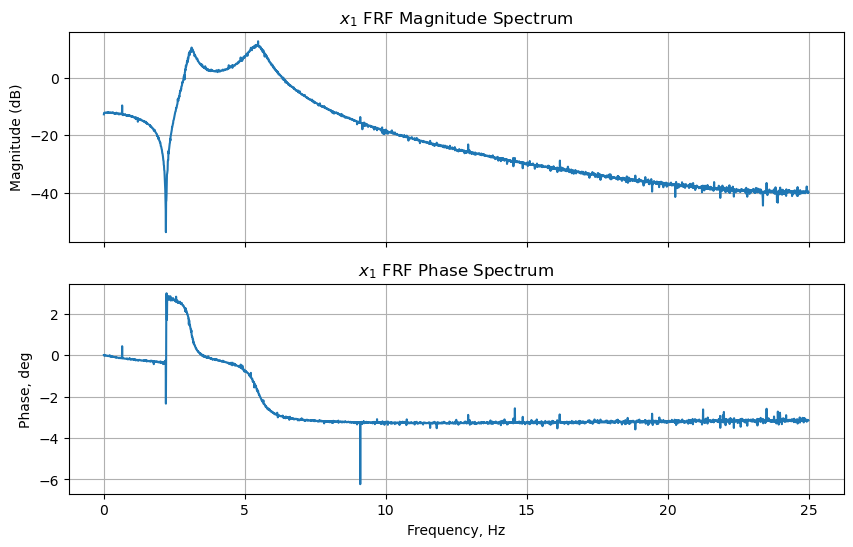

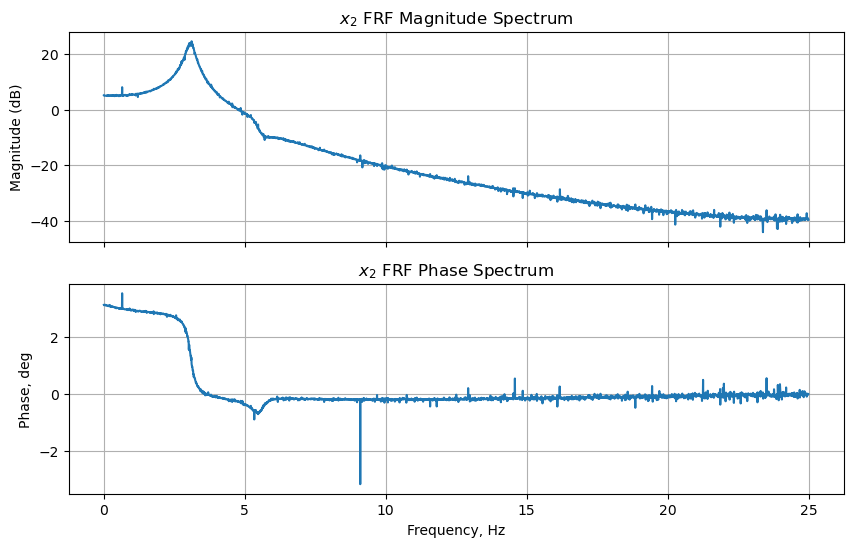

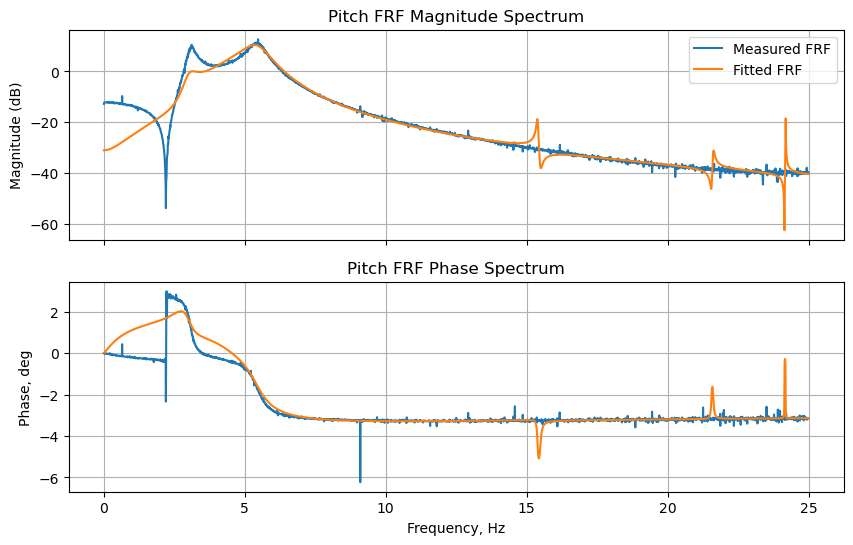

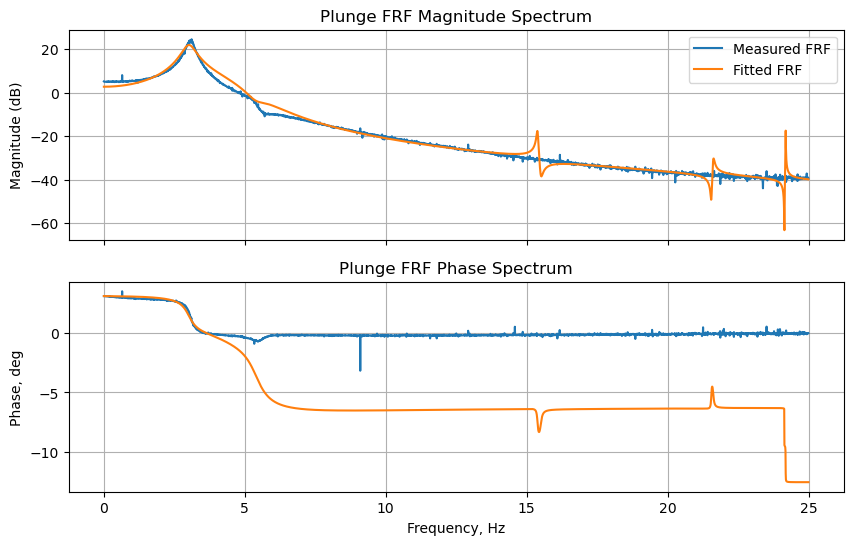

Mode 1
True natural frequency: 19.35 rad/s
Estimated natural frequency: 19.00 rad/s
Percentage error: -1.82%
True damping ratio: -0.05
Estimated damping ratio: 0.08
Percentage error: -270.52%

Mode 2
True natural frequency: 34.27 rad/s
Estimated natural frequency: 28.96 rad/s
Percentage error: -15.48%
True damping ratio: -0.06
Estimated damping ratio: 0.27
Percentage error: -576.84%

{'order': 4, 'frequencies': array([18.64712117, 35.34836926]), 'dampings': array([0.03706749, 0.0715643 ]), 'mode_shapes': array([[ 0.75993408, -0.59931454],
       [ 0.65000015,  0.80051364]])}


{'order': 6, 'frequencies': array([ 18.81852119,  34.64505484, 133.11438998]), 'dampings': array([0.04451139, 0.05268231, 0.03326572]), 'mode_shapes': array([[ 0.40239302,  0.5441666 , -0.62610473],
       [ 0.91546702,  0.83897718,  0.77973897]])}


{'order': 8, 'frequencies': array([ 18.87948401,  34.35001332,  73.05079484, 146.07353771]), 'dampings': array([0.05024687, 0.0455571 , 0.12313409, 0.00302894]), 'mo

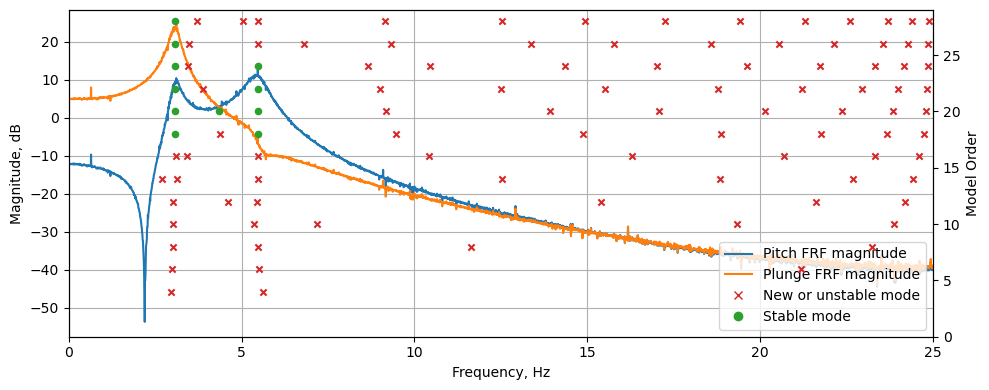

c:\Users\ngs\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 7500 is greater than input length  = 6635, using nperseg = 6635
  warnings.warn('nperseg = {0:d} is greater than input length '


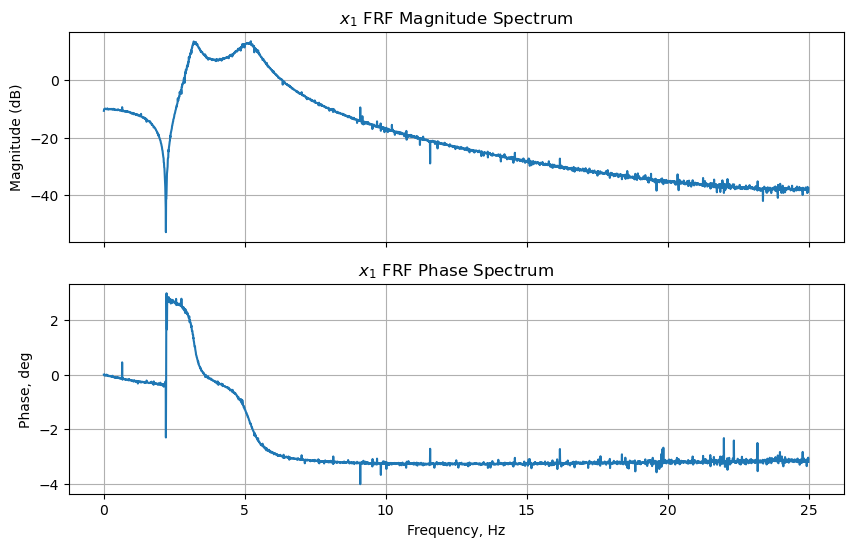

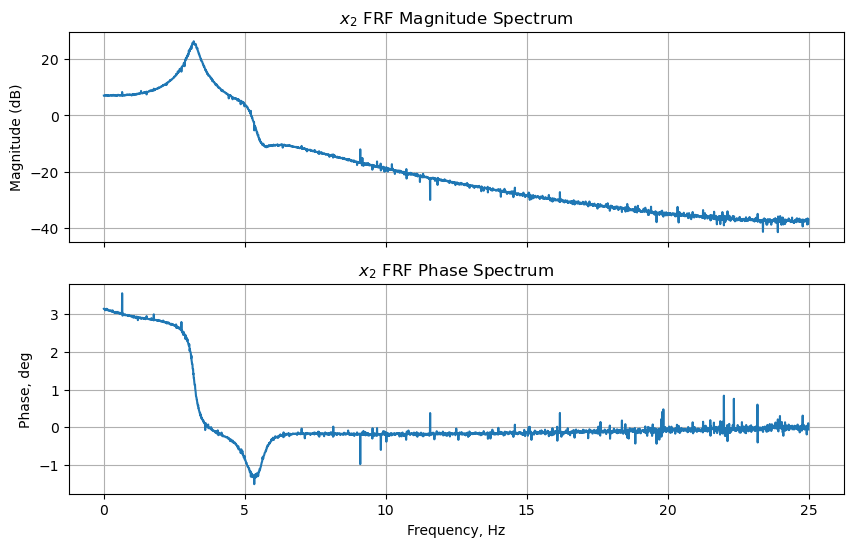

In [ ]:
from scipy.io import loadmat

# data2 = loadmat("MySystem.mat")
data2 = loadmat("SIDFiles.mat")

f_sampling = 100

# random_force_signal = data2["theta"]
# displacements1 = data2["x_gust"]
random_force_signal_array = data2["random_force_signal"]
displacements1_array = data2["displacements"]
reference_natural_frequencies_array = data2["omega"]*(2*np.pi)
reference_damping_ratios_array = data2["damp"]/100
Velocity_Time = data2["Velocity_Time"] #  50 100, 200, 210, 220, 230, 240, 256, 258, 269
# Velocity_Time = Velocity_Time[0,0]
num_order = np.ones(random_force_signal_array.shape[0], dtype=int)*12
den_order = np.ones_like(num_order, dtype=int)*12
num_order[0] = 12
den_order[0] = 12

num_order[1] = 10
den_order[1] = 10

num_order[2] = 16
den_order[2] = 16

# num_order[3] = 16
# den_order[3] = 16

# num_order[4] = 16
# den_order[4] = 16

# num_order[5] = 16
# den_order[5] = 16

# num_order[6] = 16
# den_order[6] = 16

# num_order[7] = 18
# den_order[7] = 18

# num_order[8] = 12
# den_order[8] = 12


N_DOFS = len(displacements1_array[0,0,:])


for i in range(len(random_force_signal_array[:,0])):
    random_force_signal = random_force_signal_array[i,:]
    reference_natural_frequencies = reference_natural_frequencies_array[Velocity_Time[0,i]-1,:]
    reference_damping_ratios = reference_damping_ratios_array[Velocity_Time[0,i]-1,:]
 

    displacements = np.array([displacements1_array[i,:, 0], displacements1_array[i,:, 1]])
    frequencies, frfs2 = calculate_h1_frf(
        random_force_signal, displacements, f_sampling, nperseg=7500
    )

    frfs2_bien = np.vstack([frfs2[0,:], frfs2[1,:]])

    # Plot FRF spectrum for each degree of freedom
    _, _ = plot_spectrum(frequencies, frfs2_bien[0], unwrap=True, title="$x_1$ FRF")
    plt.show()
    _, _ = plot_spectrum(frequencies, frfs2_bien[1], unwrap=True, title="$x_2$ FRF")
    plt.show()

    # Select numerator and denominator orders
    numerator_order = num_order[i]
    denominator_order = den_order[i]


    # Take symmetric frequency points around zero (exclude Nyquist frequency point)
    symmetric_mask = np.abs(frequencies) < f_sampling / 2
    symmetric_angular_frequencies = 2 * np.pi * frequencies[symmetric_mask]

    # Perform global curve fitting
    a_coeffs_list, b_coeffs, _, _, _, _ = grfp_curve_fit(
        symmetric_angular_frequencies, frfs2_bien[:, symmetric_mask], numerator_order, denominator_order
    )

    # Calculate fitted FRFs
    angular_frequencies = 2 * np.pi * frequencies
    fitted_frfs = calculate_fitted_frf(
    angular_frequencies, a_coeffs_list, b_coeffs
    )
 
    # Iterate through each DOF
    for j in range(N_DOFS):

        # Plot measured FRF
        _, axes = plot_spectrum(
            frequencies,
            frfs2_bien[j],
            unwrap=True,
            label="Measured FRF",
        )

        # Plot fitted FRF
        if j ==0:
             tit = "Pitch FRF"
        else:
            tit = "Plunge FRF"
        plot_spectrum(
            frequencies,
            fitted_frfs[j],
            unwrap=True,
            axes=axes,
            label="Fitted FRF",
            title=tit,
        )

        # Add legend and show plot
        axes[0].legend()
        plt.show()

        # Estimate modal parameters from denominator coefficients
        estimated_natural_frequencies, estimated_damping_ratios, pole_pairs = extract_poles(
            b_coeffs
        )

        # Take sorted true natural frequencies and damping ratiosn for comparison
        sort_indices = np.argsort(reference_natural_frequencies)
        reference_natural_frequencies_sorted = reference_natural_frequencies[sort_indices]
        reference_damping_ratios_sorted = reference_damping_ratios[sort_indices]

    # Compare true and estimated natural frequencies and damping ratios for each mode
    for j in range(N_DOFS):
        print(f"Mode {j+1:d}")
        print(
            f"True natural frequency: {reference_natural_frequencies_sorted[j]:.2f} rad/s"
        )
        print(f"Estimated natural frequency: {estimated_natural_frequencies[j]:.2f} rad/s")
        print(
            f"Percentage error: {100 * (estimated_natural_frequencies[j]/reference_natural_frequencies_sorted[j] - 1):.2f}%"
        )
        print(f"True damping ratio: {reference_damping_ratios_sorted[j]:.2f}")
        print(f"Estimated damping ratio: {estimated_damping_ratios[j]:.2f}")
        print(
            f"Percentage error: {100 * (estimated_damping_ratios[j]/reference_damping_ratios_sorted[j] - 1):.2f}%\n"
        )

        
    # Varying order model to check which one fits best

    # Define order range for denominator polynomial
    order_range = range(4, 30, 2)

    # Initialize list of dictionaries to store modal parameters
    modal_params_list = []

    # Iterate over each order
    for order in order_range:
        # Perform global curve fitting
        a_coeffs_list, b_coeffs, _, _, _, _ = grfp_curve_fit(
            symmetric_angular_frequencies, frfs2_bien[:, symmetric_mask], order, order
        )
        
        # Estimate modal parameters from denominator coefficients
        estimated_natural_frequencies, estimated_damping_ratios, pole_pairs = extract_poles(
            b_coeffs
        )

        # Calculate estimated mode shapes
        estimated_modes = calculate_modes(a_coeffs_list, pole_pairs)

        # Store modal parameters in dictionary
        result_dict = {
            "order": order,
            "frequencies": estimated_natural_frequencies,
            "dampings": estimated_damping_ratios,
            "mode_shapes": estimated_modes,
        }
        print(result_dict)
        print("\n")

        modal_params_list.append(result_dict)

    # Apply stabilization criteria to identify stable poles across model orders
    stabilization_results = apply_stabilization_criteria(modal_params_list)

    # Create figure with two subplots
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Plot FRF magnitude in the background
    # Get positive frequencies only
    pos_mask = frequencies >= 0
    pos_freqs = frequencies[pos_mask]
    # Iterate over each degree of freedom
    for i in range(N_DOFS):
        # Find positive-frequency portion of the FRF
        pos_spectrum = frfs2_bien[i, pos_mask]
        # Calculate magnitude
        magnitude_db = 20 * np.log10(np.abs(pos_spectrum))
        # Plot magnitude
        ax1.plot(pos_freqs, magnitude_db)

    # Add axes labels and grid
    ax1.set_xlabel("Frequency, Hz")
    ax1.set_ylabel("Magnitude, dB")
    ax1.grid(True)

    # Create a second y-axis for the stability information
    ax2 = ax1.twinx()

    # Plot markers for different stability types
    # New modes (not stable)
    new_modes = stabilization_results[stabilization_results["stability"] == "new"]
    ax2.scatter(new_modes["freq_Hz"], new_modes["order"], s=20, color=COLORS[3], marker="x")

    # Fully stable modes
    stable_modes = stabilization_results[stabilization_results["stability"] == "stable"]
    ax2.scatter(
        stable_modes["freq_Hz"], stable_modes["order"], s=20, color=COLORS[2], marker="o"
    )

    # Add axis label, limits, and grid
    ax2.set_ylabel("Model Order")
    ax2.set_xlim([0, f_sampling / 4])
    ax2.set_ylim([0, max(order_range) + 1])
    ax2.grid(False)

    # Create proxy artists for legend
    x1_line = Line2D([0], [0], color=COLORS[0], label="Pitch FRF magnitude")
    x2_line = Line2D([0], [0], color=COLORS[1], label="Plunge FRF magnitude")
    new_mode = Line2D(
        [0],
        [0],
        color=COLORS[3],
        marker="x",
        linestyle="None",
        label="New or unstable mode",
    )
    stable_mode = Line2D(
        [0], [0], color=COLORS[2], marker="o", linestyle="None", label="Stable mode"
    )

    # Add legend
    ax1.legend(handles=[x1_line, x2_line, new_mode, stable_mode], loc="lower right")

    # Set layout and show plot
    plt.tight_layout()
    plt.show()

        


In [ ]:
# def calculate_fitted_frf(angular_frequencies, a_coeffs_list, b_coeffs):
#     """
#     Calculate the fitted FRF using the polynomial coefficients.

#     Parameters:
#     ----------
#     angular_frequencies : ndarray
#         Array of angular frequencies (rad/s)
#     a_coeffs_list : list
#         List of numerator polynomial coefficients for each DOF
#     b_coeffs : ndarray
#         Denominator polynomial coefficients

#     Returns:
#     -------
#     fitted_frf : ndarray
#         Fitted FRF for each DOF
#     """
#     # Initialize arrray to store fitted FRFs
#     fitted_frfs = np.zeros((len(a_coeffs_list), len(angular_frequencies)), dtype=complex)
#     N_DOFS = 2

#     # Loop through each degree of freedom to compare measured and fitted FRFs
#     for j in range(N_DOFS):
#         # Calculate fitted FRF using the polynomial coefficients
#         num = np.polyval(a_coeffs_list[j][::-1], 1j * angular_frequencies)
#         den = np.polyval(b_coeffs[::-1], 1j * angular_frequencies)
#         fitted_frfs[j] = num / den

#     # Return the fitted FRFs
#     return fitted_frfs

# # Calculate fitted FRFs
# angular_frequencies = 2 * np.pi * frequencies
# fitted_frfs = calculate_fitted_frf(
#     angular_frequencies, a_coeffs_list, b_coeffs
# )

# N_DOFS = 2

# # Iterate through each DOF
# for j in range(N_DOFS):

#     # Plot measured FRF
#     _, axes = plot_spectrum(
#         frequencies,
#         frfs2_bien[j],
#         unwrap=True,
#         label="Measured FRF",
#     )

#     # Plot fitted FRF
#     plot_spectrum(
#         frequencies,
#         fitted_frfs[j],
#         unwrap=True,
#         axes=axes,
#         label="Fitted FRF",
#         title=f"$x_{j+1:d}$ FRF",
#     )

#     # Add legend and show plot
#     axes[0].legend()
#     plt.show()

In [ ]:
# # Calculate fitted FRFs
# N_DOFS =2
# angular_frequencies = 2 * np.pi * frequencies
# fitted_frfs = calculate_fitted_frf(
#     angular_frequencies, a_coeffs_list, b_coeffs
# )

# # Iterate through each DOF
# for j in range(N_DOFS):

#     # Plot measured FRF
#     _, axes = plot_spectrum(
#         frequencies,
#         frfs2_bien[j],
#         unwrap=True,
#         label="Measured FRF",
#     )
#     # Plot fitted FRF
#     plot_spectrum(
#         frequencies,
#         fitted_frfs[j],
#         unwrap=True,
#         axes=axes,
#         label="Fitted FRF",
#         title=f"$x_{j+1:d}$ FRF",
#     )

#     # Add legend and show plot
#     axes[0].legend()
#     plt.show()

{'order': 4, 'frequencies': array([ 5.5367781 , 11.75331711]), 'dampings': array([-2.08266492e-05, -1.76826604e-06]), 'mode_shapes': array([[0.62333458, 0.32758926],
       [0.78195524, 0.94482023]])}


{'order': 6, 'frequencies': array([ 2.60951122, 11.75062092, 74.1617262 ]), 'dampings': array([ 3.14910127e-04, -3.33313761e-06, -1.74534902e-07]), 'mode_shapes': array([[0.43879453, 0.41660797, 0.46293147],
       [0.89858742, 0.90908624, 0.88639407]])}


{'order': 8, 'frequencies': array([ 2.3562283 , 11.75049371, 34.26576159, 74.69088186]), 'dampings': array([-9.49123361e-05, -3.24133859e-06, -1.86078844e-06, -8.30796920e-07]), 'mode_shapes': array([[0.43975296, 0.38656888, 0.42577178, 0.44537717],
       [0.89811878, 0.92226054, 0.90483059, 0.89534305]])}


{'order': 10, 'frequencies': array([ 0.69826483, 11.74405951, 12.25560257, 51.56724745, 74.7428104 ]), 'dampings': array([ 3.23480896e-03, -2.10706818e-06, -3.76358844e-05,  3.27440112e-06,
       -7.96543518e-07]), 'mode_shapes'

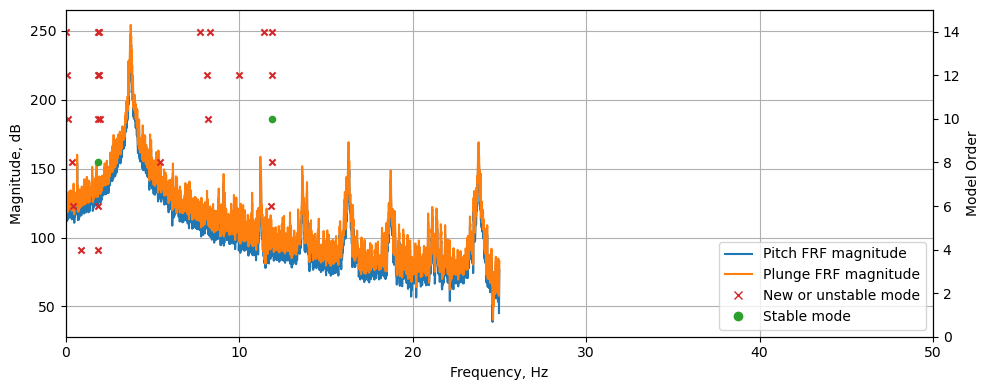

In [ ]:

# Varying order model to check which one fits best

# Define order range for denominator polynomial
order_range = range(4, 16, 2)

# Initialize list of dictionaries to store modal parameters
modal_params_list = []

# Iterate over each order
for order in order_range:
    # Perform global curve fitting
    a_coeffs_list, b_coeffs, _, _, _, _ = grfp_curve_fit(
        symmetric_angular_frequencies, frfs2_bien[:, symmetric_mask], order, order
    )
    
    # Estimate modal parameters from denominator coefficients
    estimated_natural_frequencies, estimated_damping_ratios, pole_pairs = extract_poles(
        b_coeffs
    )

    # Calculate estimated mode shapes
    estimated_modes = calculate_modes(a_coeffs_list, pole_pairs)

    # Store modal parameters in dictionary
    result_dict = {
        "order": order,
        "frequencies": estimated_natural_frequencies,
        "dampings": estimated_damping_ratios,
        "mode_shapes": estimated_modes,
    }
    print(result_dict)
    print("\n")

    modal_params_list.append(result_dict)

# Apply stabilization criteria to identify stable poles across model orders
stabilization_results = apply_stabilization_criteria(modal_params_list)

# Create figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot FRF magnitude in the background
# Get positive frequencies only
pos_mask = frequencies >= 0
pos_freqs = frequencies[pos_mask]
# Iterate over each degree of freedom
for i in range(N_DOFS):
    # Find positive-frequency portion of the FRF
    pos_spectrum = frfs2_bien[i, pos_mask]
    # Calculate magnitude
    magnitude_db = 20 * np.log10(np.abs(pos_spectrum))
    # Plot magnitude
    ax1.plot(pos_freqs, magnitude_db)

# Add axes labels and grid
ax1.set_xlabel("Frequency, Hz")
ax1.set_ylabel("Magnitude, dB")
ax1.grid(True)

# Create a second y-axis for the stability information
ax2 = ax1.twinx()

# Plot markers for different stability types
# New modes (not stable)
new_modes = stabilization_results[stabilization_results["stability"] == "new"]
ax2.scatter(new_modes["freq_Hz"], new_modes["order"], s=20, color=COLORS[3], marker="x")

# Fully stable modes
stable_modes = stabilization_results[stabilization_results["stability"] == "stable"]
ax2.scatter(
    stable_modes["freq_Hz"], stable_modes["order"], s=20, color=COLORS[2], marker="o"
)

# Add axis label, limits, and grid
ax2.set_ylabel("Model Order")
ax2.set_xlim([0, f_sampling / 2])
ax2.set_ylim([0, max(order_range) + 1])
ax2.grid(False)

# Create proxy artists for legend
x1_line = Line2D([0], [0], color=COLORS[0], label="Pitch FRF magnitude")
x2_line = Line2D([0], [0], color=COLORS[1], label="Plunge FRF magnitude")
new_mode = Line2D(
    [0],
    [0],
    color=COLORS[3],
    marker="x",
    linestyle="None",
    label="New or unstable mode",
)
stable_mode = Line2D(
    [0], [0], color=COLORS[2], marker="o", linestyle="None", label="Stable mode"
)

# Add legend
ax1.legend(handles=[x1_line, x2_line, new_mode, stable_mode], loc="lower right")

# Set layout and show plot
plt.tight_layout()
plt.show()